In [2]:
# %load_ext autotime
# !pip install autotime
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import os
import warnings
import pandas as pd
import numpy as np
import esm
import biotite.structure.io as bsio

from proteinttt.models.esmfold import ESMFoldTTT, DEFAULT_ESMFOLD_TTT_CFG
from proteinttt.utils.structure import calculate_tm_score, lddt_score

import seaborn as sns
import matplotlib.pyplot as plt

import torch
print(f"CUDA available: {torch.cuda.is_available()}")

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 100)

base_path = Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/data/bfvd/bfvd_logan")
DATASET_PATH = Path("/scratch/project/open-32-14/antonb/bfvd/bfvd_logan.fasta")
OUTPUT_PDB = base_path / Path('predicted_structures')
SUMMARY_PATH = base_path / Path('summary.tsv')

CORRECT_PREDICTED_PDB = Path("/scratch/project/open-32-14/antonb/bfvd/bfvd")
# os.makedirs(CDR_PATH, exist_ok=True)

# os.makedirs(base_path, exist_ok=True)

/scratch/project/open-32-14/pimenol1/miniconda3/envs/esmfold/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA available: False


In [18]:
df = pd.read_csv(Path("/scratch/project/open-32-14/antonb/bfvd") / Path("2023_02_v2-entry_nmsa_plddt_version.tsv"), sep='\t', names=['id', 'nmsa', 'plddt', 'version'], header=None)

In [ ]:
from proteinttt.utils.parsers import fetch_and_parse_sequences
df_new = fetch_and_parse_sequences(df, CORRECT_PREDICTED_PDB, 'id')
# df_new.to_csv(path_or_buf=base_path / "summary_try.tsv", sep="\t", index=False)

# Dataset

In [4]:
df = pd.read_csv(SUMMARY_PATH, sep="\t")
df.pLDDT_after.notna().sum()

85

In [6]:
# rows = []
# with open(DATASET_PATH) as fh:
#     for title, seq in SimpleFastaParser(fh):
#         rows.append({"id": title, "seq": seq, "len": len(seq)})
# df = pd.DataFrame(rows)
# df.head(5)

In [9]:
df.query("len<400").shape[0]

85

# Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

base_model = esm.pretrained.esmfold_v1().eval().to(device)

ttt_cfg = DEFAULT_ESMFOLD_TTT_CFG
ttt_cfg.steps = 20
ttt_cfg.seed = 0
model = ESMFoldTTT.ttt_from_pretrained(base_model,
                                       ttt_cfg=ttt_cfg,
                                       esmfold_config=base_model.cfg).to(device)

In [12]:
def predict_structure(model, sequence, pdb_id, tag, out_dir=OUTPUT_PDB):
    with torch.no_grad():
        pdb_str = model.infer_pdb(sequence)

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    out_path = out_dir / f"{pdb_id}{tag}.pdb"
    out_path.write_text(pdb_str)

    struct = bsio.load_structure(out_path, extra_fields=["b_factor"])
    pLDDT = float(np.asarray(struct.b_factor, dtype=float).mean())

    return pLDDT


def fold_chain(sequence, pdb_id, *, model, tag, out_dir=OUTPUT_PDB):
    model.ttt(sequence)
    pLDDT_after = predict_structure(model, sequence, pdb_id, tag='_ttt', out_dir=out_dir)
    model.ttt_reset()
    return pLDDT_after

def calculate_metrics(true_path, pred_path):
    true_struct = bsio.load_structure(true_path, extra_fields=["b_factor"])
    plddt_alpha = float(np.asarray(true_struct.b_factor, dtype=float).mean())
    
    tm_score = calculate_tm_score(pred_path, true_path)
    lddt = lddt_score(true_path, pred_path)

    return tm_score, lddt, plddt_alpha

In [13]:
num_of_low = 0
col = 'seq'

In [14]:
for i, row in df.iterrows():
    if pd.isna(row['pLDDT_after']):
        continue
    id = str(row.get("id"))
    
    tm_score_before, lddt_before, pldd_alphafold = calculate_metrics(
        true_path=CORRECT_PREDICTED_PDB / f"{id}.pdb",
        pred_path=OUTPUT_PDB / f"{id}.pdb"
    )
    tm_score_after, lddt_after, _ = calculate_metrics(
        true_path=CORRECT_PREDICTED_PDB / f"{id}.pdb",
        pred_path=OUTPUT_PDB / f"{id}_ttt.pdb"
    )
    
    df.at[i, 'tm_score_before'] = tm_score_before
    df.at[i, 'lddt_before'] = lddt_before
    
    df.at[i, 'lddt_after'] = lddt_after
    df.at[i, 'tm_score_after'] = tm_score_after
    
    df.at[i, 'plddt_AlphaFold'] = pldd_alphafold

    print(f"tm_score before: {tm_score_before:.3f}, after: {tm_score_after:.3f}; ")


tm_score before: 0.893, after: 0.886; 
tm_score before: 0.516, after: 0.510; 
tm_score before: 0.480, after: 0.388; 
tm_score before: 0.473, after: 0.490; 
tm_score before: 0.304, after: 0.215; 
tm_score before: 0.579, after: 0.704; 
tm_score before: 0.910, after: 0.919; 
tm_score before: 0.266, after: 0.244; 
tm_score before: 0.660, after: 0.676; 
tm_score before: 0.306, after: 0.296; 
tm_score before: 0.291, after: 0.265; 
tm_score before: 0.848, after: 0.851; 
tm_score before: 0.643, after: 0.671; 
tm_score before: 0.274, after: 0.263; 
tm_score before: 0.566, after: 0.604; 
tm_score before: 0.387, after: 0.835; 
tm_score before: 0.356, after: 0.321; 
tm_score before: 0.356, after: 0.367; 
tm_score before: 0.918, after: 0.913; 
tm_score before: 0.289, after: 0.289; 
tm_score before: 0.695, after: 0.643; 
tm_score before: 0.262, after: 0.252; 
tm_score before: 0.871, after: 0.778; 
tm_score before: 0.558, after: 0.406; 
tm_score before: 0.491, after: 0.618; 
tm_score before: 0.323, a

In [15]:
df['tm_score_difference'] = df['tm_score_after'] - df['tm_score_before']

In [ ]:
c = 0
for i, row in df.iterrows():
    if row['len'] > 500 or pd.notna(row['pLDDT_after']):
        continue
    c += 1
    id = str(row.get("id"))

    if pd.isna(row[col]):
        continue
    seq = str(row[col]).strip().upper()
    
    try:
        pLDDT_before = predict_structure(model, seq, id, tag="")
    except Exception as e:
        warnings.warn(f"{id}: {e}")
        pLDDT_before = np.nan

    try:
        pLDDT_after = fold_chain(seq, id, model=model, tag="")
    except Exception as e:
        warnings.warn(f"{id}: {e}")
        pLDDT_after = np.nan

    df.at[i, 'pLDDT_after'] = pLDDT_after
    df.at[i, 'pLDDT_before'] = pLDDT_before

    if c % 10 == 0:
        df.to_csv(path_or_buf=SUMMARY_PATH, sep="\t", index=False)

df.to_csv(SUMMARY_PATH, sep="\t", index=False)

In [ ]:
# sub_df.pLDDT_before.describe(), sub_df.pLDDT_after.describe()

(count    50.000000
 mean     50.466644
 std      17.633325
 min      27.102779
 25%      35.317681
 50%      44.525460
 75%      64.263426
 max      89.990320
 Name: pLDDT_before, dtype: float64,
 count    50.000000
 mean     59.263574
 std      16.118438
 min      31.419610
 25%      46.915984
 50%      56.878659
 75%      72.440317
 max      89.990320
 Name: pLDDT_after, dtype: float64)

Entries with pLDDT before and after: 85


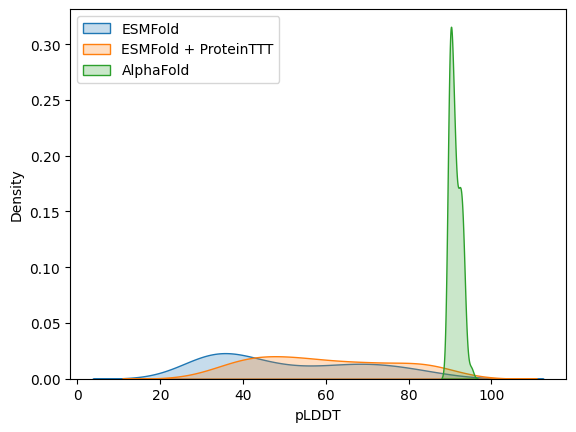

In [5]:
sub_df = df.query("pLDDT_before.notna() and pLDDT_after.notna()")
print(f"Entries with pLDDT before and after: {len(sub_df):,}")

sns.kdeplot(sub_df['pLDDT_before'], label='ESMFold', fill=True)
sns.kdeplot(sub_df['pLDDT_after'], label='ESMFold + ProteinTTT', fill=True)
sns.kdeplot(sub_df['plddt_AlphaFold'], label='AlphaFold', fill=True)
plt.xlabel('pLDDT')
plt.legend()
plt.show()

0.9216761073455133 0.8882696881363623


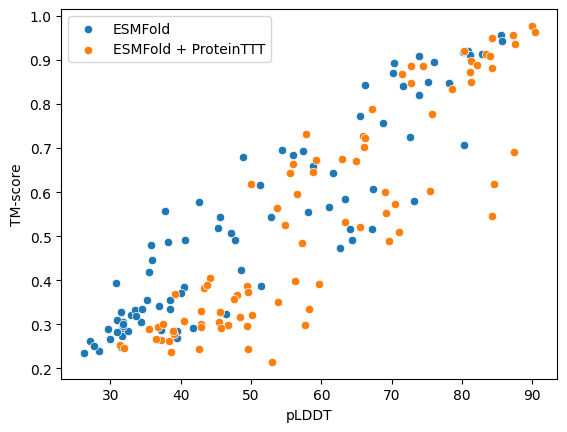

In [6]:
print(np.corrcoef(sub_df['pLDDT_before'], sub_df['tm_score_before'])[0, 1], np.corrcoef(sub_df['pLDDT_after'], y=sub_df['tm_score_after'])[0, 1])
sns.scatterplot(data=sub_df, x='pLDDT_before', y='tm_score_before', label='ESMFold')
sns.scatterplot(data=sub_df, x='pLDDT_after', y='tm_score_after', label='ESMFold + ProteinTTT')
plt.xlabel('pLDDT')
plt.ylabel('TM-score')
plt.legend()
plt.show()

0.969453072964751 0.9549817572334818


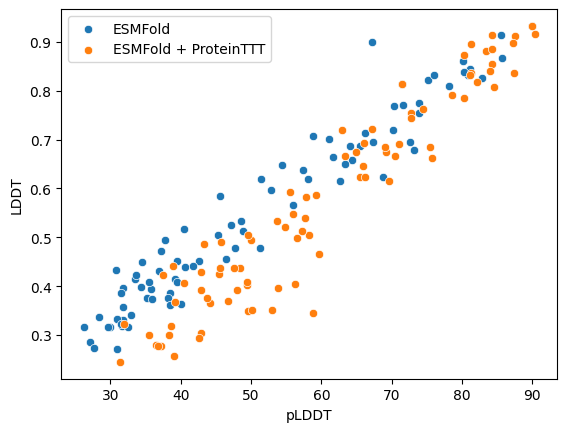

In [8]:
print(np.corrcoef(sub_df['pLDDT_before'], sub_df['lddt_before'])[0, 1], np.corrcoef(sub_df['pLDDT_after'], sub_df['lddt_after'])[0, 1])
sns.scatterplot(sub_df, x='pLDDT_before', y='lddt_before', label='ESMFold')
sns.scatterplot(sub_df, x='pLDDT_after', y='lddt_after', label='ESMFold + ProteinTTT')
plt.xlabel('pLDDT')
plt.ylabel('LDDT')
plt.legend()

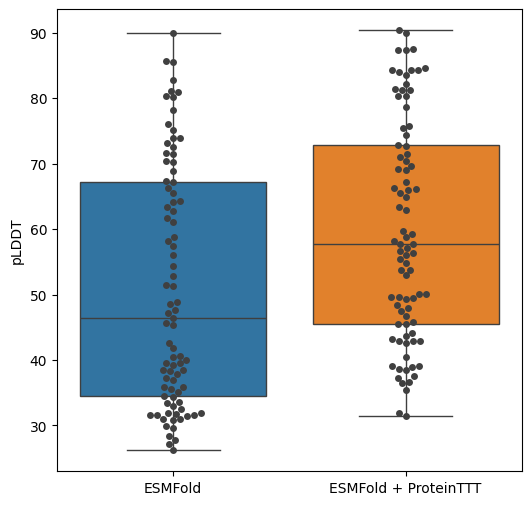

In [8]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=sub_df[['pLDDT_before', 'pLDDT_after']])
sns.swarmplot(data=sub_df[['pLDDT_before', 'pLDDT_after']], color=".25")
plt.ylabel('pLDDT')
plt.xticks([0, 1], ['ESMFold', 'ESMFold + ProteinTTT'])
plt.show()  

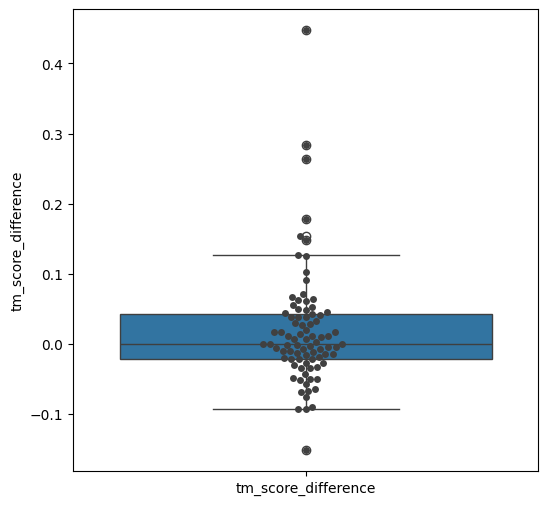

In [9]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=sub_df[['tm_score_difference']])
sns.swarmplot(data=sub_df[['tm_score_difference']], color=".25")
plt.ylabel('tm_score_difference')
# plt.xticks([0, 1], ['tm_score_difference'])
plt.show()

In [10]:
sub_df.pLDDT_before.describe(), sub_df.pLDDT_after.describe()

(count    85.000000
 mean     50.970040
 std      18.292228
 min      26.214635
 25%      34.465891
 50%      46.402697
 75%      67.241621
 max      89.990320
 Name: pLDDT_before, dtype: float64,
 count    85.000000
 mean     59.817569
 std      16.730841
 min      31.419610
 25%      45.558490
 50%      57.731184
 75%      72.765469
 max      90.359866
 Name: pLDDT_after, dtype: float64)

In [20]:
sub_df

,id,seq,len,pLDDT_after,pLDDT_before,tm_score_before,lddt_before,lddt_after,tm_score_after,plddt_AlphaFold,tm_score_difference
0,R4T8R0,MTVGIICLDGLDHRLASEHDIFDPVSASVQPLVNDLSGEGRLFTPRVWNSLFLGEDQQEILGWLPEPKWKTATRDWDFLWDKVVGTSLLNVNVHSN...,249,72.765469,70.338475,0.89281,0.769153,0.754586,0.88602,95.100833,-0.00679
1,A0A221LFE8,MSTNIGDLIFDSGKTLFEILDSLDVANVSQQLDSANMRLDEVNDQLRQLSSIVDTNQANNNASFISVNTQLDDINIEVAALTVQLAPLVVEIDNLS...,274,70.998282,64.136403,0.51598,0.687284,0.690853,0.51012,91.680119,-0.00586
2,A0A7D3UVQ1,MSELVFFKHDQVWNDRNIISTHHAEAGYKRAVATIGAILTDLAAQIDDNIKTVIAGYHRGYSPTAVADQMVTTALDNLERWLPYNSGNGATDSARE...,203,49.442994,35.834331,0.48040,0.394021,0.401617,0.38782,90.422505,-0.09258
3,A0A6J4EGK9,MAWYNKMDKIPRKYFYWEGNIIRTIYSNQRGFWLVRGRNLVRCDADGNILDPKDFLYATSTEATMSIPQVINGWLWRDMNKGLYPDFDAYNEQERQ...,216,69.694359,62.701464,0.47282,0.616146,0.614851,0.48970,89.567034,0.01688
4,A0A8S5P0T1,MAKELTRDDIIKKQYSELNKINQRLKNISECYYISYDGTIYMKSLVPFVEKMIHLRYPEKINLFYGAMILPNQFFDYAKKAKKSKMTIKENDTSFE...,236,52.954205,31.835611,0.30421,0.329957,0.351502,0.21460,94.074701,-0.08961
5,A0A8S5UE13,MAKLPSLITNSLTGEALNYSNSGSGKVEIKQTFEVTQNNNNFTWTIKSKIYIRLNSGYPQGKGERFSGIWQQIGDGINKIIEDIQILSLSGVWINN...,202,66.129042,42.648223,0.57865,0.451281,0.693613,0.70353,91.871825,0.12488
7,A0A1L7N0X1,MGPVQRSIGYLQGGYKDSTVHSKVQLFNTTTQVGQLVYDTGYQRNYRPGISGAYNGYFSISDTTAYNKFNYITASASASFTTARDPSVSVSDLNVY...,292,80.284180,73.850115,0.91012,0.754990,0.785840,0.91942,89.522860,0.00930
8,A0A481YVQ9,MSLICHDIDYIIASHIFNSYYRDGCDDLKNIMISFGKSSYDDFIGMCRCVFFRMLFARYKCKDVNVCTLLQKLSHKNNIKHFQCYNKFNDNLGNNQ...,203,49.611977,29.975052,0.26616,0.316754,0.349014,0.24423,93.533424,-0.02193
9,A0A6B7ZEG3,MTLINKAFAQQAKEEIIKHLRTQLEGKANSNTFNLKDSGITVTIRTTANPHTKLTKFEVYVFDRMVGSGEVKFDKKIQLEKSFVETLPDFIMTHLL...,203,62.906671,58.752945,0.65972,0.706497,0.718601,0.67622,91.647061,0.01650
11,A0A0K2QRL1,MLGSEHKERYDQMEEEINFRSTDFWFMRDPDAPEDDELNFVVDFLLQEFMHVGPFGHSFVKEHQGKWKPSFYGVPLQHLFIHPSTDGFEAMAFVAS...,228,49.361439,34.330579,0.30595,0.398895,0.409251,0.29599,89.611277,-0.00996
